In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from glob import glob
import cv2
import torch
from PIL import Image
import tqdm

from rsl_depth_completion.diffusion.inference_utils import sample
from rsl_depth_completion.diffusion.configs import DiffusionConfig
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision as tv
from rsl_depth_completion.diffusion.training_utils import q_sample
from rsl_depth_completion.diffusion.utils import extract
from rsl_depth_completion.diffusion.utils import set_seed
from torchvision.utils import save_image
from rsl_depth_completion.diffusion.schedulers import (cosine_beta_schedule,
linear_beta_schedule,
quadratic_beta_schedule,
sigmoid_beta_schedule)
import torch.nn.functional as F
from torch.optim import Adam
import gc

from pathlib import Path
import shutil

%matplotlib inline

# config

In [3]:
input_channels = 1
timesteps = 200
# timesteps = 30

seed = 100
set_seed(seed)

run_name='test'
results_folder = Path("./imagen_results") / run_name
shutil.rmtree(results_folder, ignore_errors=True)
results_folder.mkdir(parents=True,exist_ok = True)

init_image_size = (352, 1216)
crop_image_size = (352, 1216 // 3)
target_image_size = (152, 200)
input_channels = 1
batch_size = 2



# model

In [5]:
from rsl_depth_completion.conditional_diffusion.utils import get_model_params
from rsl_depth_completion.conditional_diffusion.train import MinimagenTrain

In [6]:
import os
from datetime import datetime

import torch.utils.data
from torch import optim
from minimagen.Imagen import Imagen
from minimagen.Unet import Unet
from minimagen.training import (
    ConceptualCaptions,
    get_minimagen_dl_opts,
    create_directory,
)



In [74]:
import argparse
import torch
args = argparse.Namespace(**{
    "PARAMETERS": "./imagen_parameters",
    "BATCH_SIZE": 2,
    "NUM_WORKERS": 0,
    "EPOCHS": 5,
    "OPTIM_LR": 0.001,
    "ACCUM_ITER": 1,
    "CHCKPT_NUM": 500,
})
params = get_model_params(args.PARAMETERS)
data_args = argparse.Namespace(
    **{
        "MAX_NUM_WORDS": 64,
        "T5_NAME": params['imagen_parameters']['text_encoder_name'],
        "IMG_SIDE_LEN": params['imagen_parameters']["image_sizes"][1],
        "TRAIN_VALID_FRAC": 0.9,
    }
)


In [71]:

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
timestamp = '20230418_205025'
dir_path = f"./training_{timestamp}"
training_dir = create_directory(dir_path)

In [53]:
from datasets import load_dataset
from minimagen.training import MinimagenDataset

dset = load_dataset("conceptual_captions")

No config specified, defaulting to: conceptual_captions/unlabeled
Found cached dataset conceptual_captions (/media/master/text/cv_data/hf_home/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


  0%|          | 0/2 [00:00<?, ?it/s]

In [60]:
train_val_num = args.BATCH_SIZE*3
val_num = args.BATCH_SIZE+1
vi = dset["validation"]["image_url"][:val_num]
vc = dset["validation"]["caption"][:val_num]
ti = dset["train"]["image_url"][:train_val_num]
tc = dset["train"]["caption"][:train_val_num]
new_dset = {
    "train": {
        "image_url": ti,
        "caption": tc,
    },
    "num_rows": train_val_num,
    "validation": {
        "image_url": vi,
        "caption": vc,
    },
    "num_rows": val_num,
}
print(len(new_dset["train"]["image_url"]))

6


In [64]:
dataset_train_valid = MinimagenDataset(
    new_dset,
    max_length=data_args.MAX_NUM_WORDS,
    encoder_name=data_args.T5_NAME,
    train=True,
    side_length=data_args.IMG_SIDE_LEN,
)

# Split into train/valid
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset_train_valid, [2,4]
    # dataset_train_valid, [train_num, val_num]
)

dl_opts = {
    **get_minimagen_dl_opts(device),
    "batch_size": args.BATCH_SIZE,
    "num_workers": args.NUM_WORKERS,
}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **dl_opts)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, **dl_opts)


In [66]:
len(train_dataloader), len(valid_dataloader)

(1, 2)

In [67]:
x_train=next(iter(train_dataloader))
x_val=next(iter(valid_dataloader))

In [72]:
import gc; gc.collect()
torch.cuda.empty_cache()

In [85]:
import json

with open("full_params.json", "w") as f:
    f.write(json.dumps(params))

In [80]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create Unets accoridng to unets_params
unets = [Unet(**params['unet_base']).to(device), Unet(**params['unet_super_resolution']).to(device)]

# Create Imagen from UNets with specified imagen parameters
imagen = Imagen(unets=unets, **params['imagen_parameters']).to(device)
args.OPTIM_LR = 0.005
optimizer = optim.Adam(imagen.parameters(), lr=args.OPTIM_LR)

In [86]:
args.EPOCHS=30
train_unet_losses, val_unet_losses=MinimagenTrain(
    timestamp,
    args,
    unets,
    imagen,
    train_dataloader,
    valid_dataloader,
    training_dir,
    optimizer,
)


### Epoch 1 of 30 ###


train: 100%|██████████| 1/1 [01:03<00:00, 63.57s/it]


(Base,SuperR) Unets Train Loss: (0.21916, 0.71512)


valid: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


(Base,SuperR) Unets Val Loss: (0.17924, 0.70723)
### Epoch 2 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


(Base,SuperR) Unets Train Loss: (0.25681, 0.71143)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


(Base,SuperR) Unets Val Loss: (0.26276, 0.70639)
### Epoch 3 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


(Base,SuperR) Unets Train Loss: (0.43611, 0.73812)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


(Base,SuperR) Unets Val Loss: (0.20471, 0.75362)
### Epoch 4 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


(Base,SuperR) Unets Train Loss: (0.25396, 0.73121)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


(Base,SuperR) Unets Val Loss: (0.17267, 0.70168)
### Epoch 5 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


(Base,SuperR) Unets Train Loss: (0.16455, 0.69866)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


(Base,SuperR) Unets Val Loss: (0.15571, 0.76447)
### Epoch 6 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


(Base,SuperR) Unets Train Loss: (0.15315, 0.68423)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


(Base,SuperR) Unets Val Loss: (0.24898, 0.76699)
### Epoch 7 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


(Base,SuperR) Unets Train Loss: (0.14322, 0.67151)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


(Base,SuperR) Unets Val Loss: (0.19181, 0.75597)
### Epoch 8 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


(Base,SuperR) Unets Train Loss: (0.13928, 0.70827)


valid: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


(Base,SuperR) Unets Val Loss: (0.42538, 0.68204)
### Epoch 9 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


(Base,SuperR) Unets Train Loss: (0.21909, 0.66066)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


(Base,SuperR) Unets Val Loss: (0.18523, 0.65383)
### Epoch 10 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


(Base,SuperR) Unets Train Loss: (0.1277, 0.73936)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


(Base,SuperR) Unets Val Loss: (0.13158, 0.73428)
### Epoch 11 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


(Base,SuperR) Unets Train Loss: (0.10952, 0.65231)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


(Base,SuperR) Unets Val Loss: (0.1813, 0.75487)
### Epoch 12 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


(Base,SuperR) Unets Train Loss: (0.15236, 0.64845)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


(Base,SuperR) Unets Val Loss: (0.13866, 0.68316)
### Epoch 13 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


(Base,SuperR) Unets Train Loss: (0.09765, 0.63364)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]


(Base,SuperR) Unets Val Loss: (0.15746, 0.64023)
### Epoch 14 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


(Base,SuperR) Unets Train Loss: (0.45017, 0.63212)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


(Base,SuperR) Unets Val Loss: (0.17044, 0.62606)
### Epoch 15 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


(Base,SuperR) Unets Train Loss: (0.09147, 0.62059)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


(Base,SuperR) Unets Val Loss: (0.10241, 0.64023)
### Epoch 16 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


(Base,SuperR) Unets Train Loss: (0.08121, 0.64272)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


(Base,SuperR) Unets Val Loss: (0.34038, 0.60914)
### Epoch 17 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(Base,SuperR) Unets Train Loss: (0.10606, 0.745)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


(Base,SuperR) Unets Val Loss: (0.14637, 0.63633)
### Epoch 18 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


(Base,SuperR) Unets Train Loss: (0.09729, 0.61708)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


(Base,SuperR) Unets Val Loss: (0.20088, 0.81746)
### Epoch 19 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


(Base,SuperR) Unets Train Loss: (0.11088, 0.60685)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


(Base,SuperR) Unets Val Loss: (0.06716, 0.60712)
### Epoch 20 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


(Base,SuperR) Unets Train Loss: (0.08507, 0.61743)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


(Base,SuperR) Unets Val Loss: (0.12818, 0.67541)
### Epoch 21 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


(Base,SuperR) Unets Train Loss: (0.38574, 0.68791)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


(Base,SuperR) Unets Val Loss: (0.11393, 0.63594)
### Epoch 22 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


(Base,SuperR) Unets Train Loss: (0.08387, 0.68649)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


(Base,SuperR) Unets Val Loss: (0.07415, 0.68295)
### Epoch 23 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


(Base,SuperR) Unets Train Loss: (0.07547, 0.79236)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


(Base,SuperR) Unets Val Loss: (0.08572, 0.71514)
### Epoch 24 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


(Base,SuperR) Unets Train Loss: (0.06605, 0.62885)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


(Base,SuperR) Unets Val Loss: (0.27424, 0.61035)
### Epoch 25 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


(Base,SuperR) Unets Train Loss: (0.05759, 0.61972)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


(Base,SuperR) Unets Val Loss: (0.07759, 0.68704)
### Epoch 26 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


(Base,SuperR) Unets Train Loss: (0.06179, 0.88811)


valid: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


(Base,SuperR) Unets Val Loss: (0.53728, 0.59249)
### Epoch 27 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


(Base,SuperR) Unets Train Loss: (0.05999, 0.58678)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


(Base,SuperR) Unets Val Loss: (0.3002, 0.60313)
### Epoch 28 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


(Base,SuperR) Unets Train Loss: (0.06462, 0.57691)


valid: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


(Base,SuperR) Unets Val Loss: (0.28049, 0.63685)
### Epoch 29 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


(Base,SuperR) Unets Train Loss: (0.21589, 0.57302)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


(Base,SuperR) Unets Val Loss: (0.04978, 0.57626)
### Epoch 30 of 30 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


(Base,SuperR) Unets Train Loss: (0.07234, 0.76016)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

(Base,SuperR) Unets Val Loss: (0.29645, 0.57337)


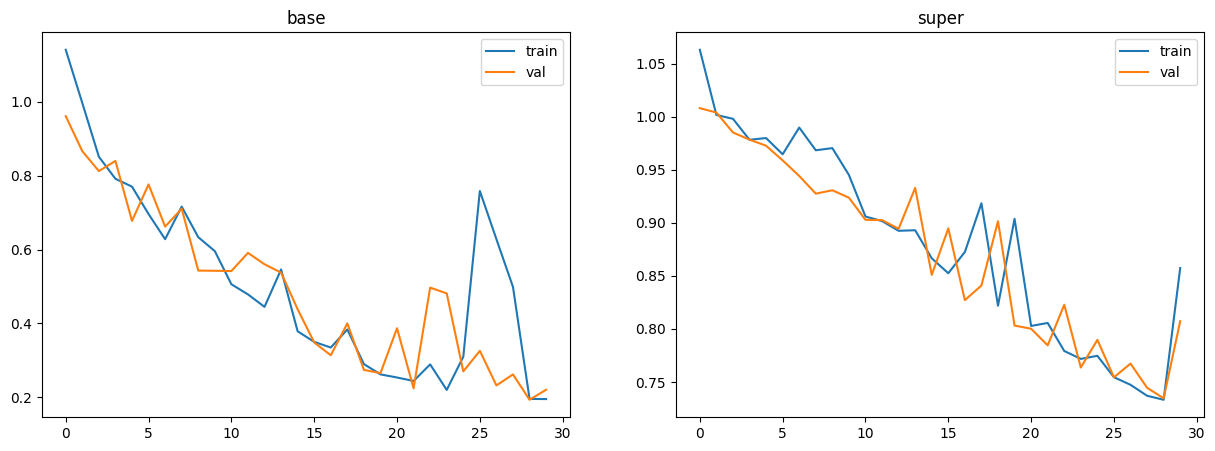

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, unet_name in enumerate(['base', 'super']):
    ax[i].set_title(unet_name)
    ax[i].plot(train_unet_losses[unet_name], label='train')
    ax[i].plot(val_unet_losses[unet_name], label='val')
    ax[i].legend()